In [1]:
!pip install nltk

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
import pickle
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score,precision_score

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
df = pd.read_csv('/kaggle/input/fake-reviews-dataset/fake reviews dataset.csv')

df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [5]:
df.drop(columns = {'category'}, inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  40432 non-null  float64
 1   label   40432 non-null  object 
 2   text_   40432 non-null  object 
dtypes: float64(1), object(2)
memory usage: 947.8+ KB


In [7]:
df.rename(columns = {'text_': 'text'}, inplace = True)

In [8]:
df.head()

,rating,label,text
0,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,5.0,CG,"love it, a great upgrade from the original. I..."
2,5.0,CG,This pillow saved my back. I love the look and...
3,1.0,CG,"Missing information on how to use it, but it i..."
4,5.0,CG,Very nice set. Good quality. We have had the s...


In [9]:
def encode_label(df):
    labels = {
        'CG': 0,
        'OR': 1
    }
    
    df['target'] = df['label'].map(labels)
    
    return df

In [10]:
df = encode_label(df)
df['target'] = df['target'].fillna(0).replace([np.inf, -np.inf], 0)
df['target'] = df['target'].astype(int)
df.head()

,rating,label,text,target
0,5.0,CG,"Love this! Well made, sturdy, and very comfor...",0
1,5.0,CG,"love it, a great upgrade from the original. I...",0
2,5.0,CG,This pillow saved my back. I love the look and...,0
3,1.0,CG,"Missing information on how to use it, but it i...",0
4,5.0,CG,Very nice set. Good quality. We have had the s...,0


In [11]:
df.drop(columns = {'rating', 'label'}, inplace = True)

In [12]:
df = df.sample(frac=1).reset_index(drop=True)

df.sample(10)

,text,target
35211,High quality stainless faucet at a great price...,1
14888,it does the job but i wish it had 2 more strap...,1
2276,These pill pockets have saved my puppy and she...,0
5317,"I don't know what else to say, but it is a gre...",0
6090,I can find my dog when shes out at night---I L...,1
14119,I had doubts with this set but purchased it ba...,1
37168,These are very comfortable. They have the wid...,0
2764,"An entertaining, if slightly improbable, movie...",0
28570,What an amazing way to end this series!\n\nWhe...,1
34651,"Brand new, the Spaulding 64-497 Official NBA Z...",1


In [13]:
df.isnull().sum()

text      0
target    0
dtype: int64

In [14]:
df.duplicated().sum()

20

In [15]:
df.drop_duplicates(inplace = True)

In [16]:
df.duplicated().sum()

0

In [17]:
df['target'].value_counts()

target
1    20215
0    20197
Name: count, dtype: int64

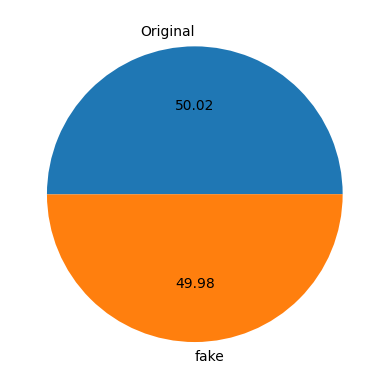

In [18]:
plt.pie(df['target'].value_counts(), labels=['Original', 'fake'],autopct="%0.2f")
plt.show()

In [19]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [20]:
df.head()

,text,target,num_characters,num_words,num_sentences
0,I bought these headphones due to the great pri...,1,396,83,6
1,I am very pleased with this product and the qu...,0,152,32,3
2,A great sci-fi movie to own; it is entertaing ...,1,64,15,1
3,"Okay, so I finally got around to reading the n...",0,598,124,8
4,It was an enjoyable movie but just not as good...,1,91,19,1


In [21]:
df.describe()

,target,num_characters,num_words,num_sentences
count,40412.000000,40412.000000,40412.000000,40412.000000
mean,0.500223,351.365337,76.640849,5.275487
std,0.500006,369.871842,79.176214,4.914497
min,0.000000,24.000000,2.000000,1.000000
25%,0.000000,107.000000,24.000000,2.000000
50%,1.000000,198.000000,44.000000,3.000000
75%,1.000000,439.000000,96.000000,6.000000
max,1.000000,2827.000000,510.000000,133.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

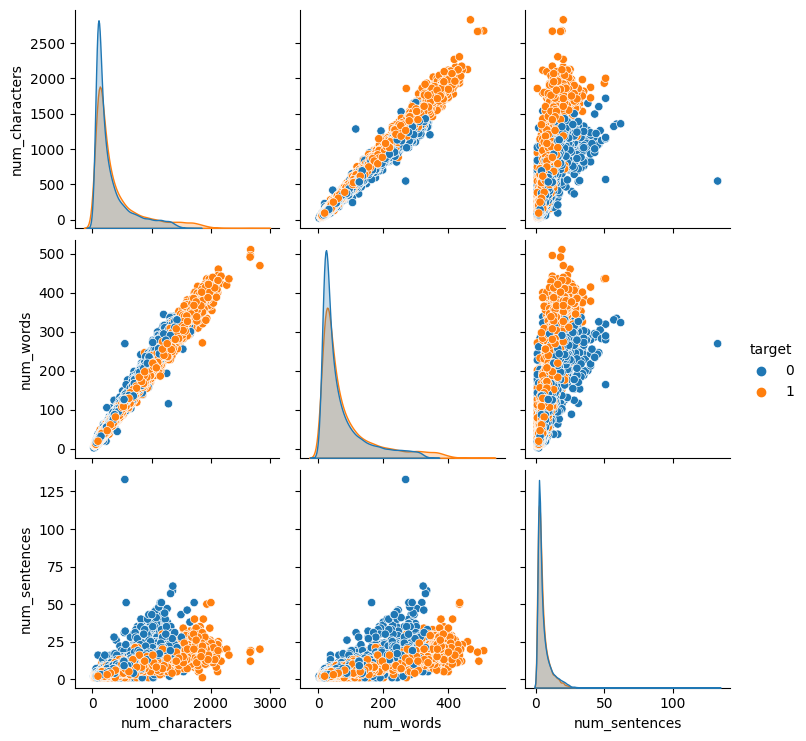

In [22]:
sns.pairplot(df,hue='target')

<Axes: >

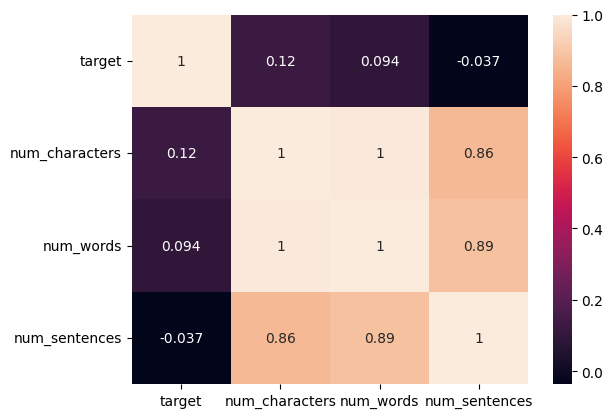

In [23]:
df_numeric = df.select_dtypes(include = 'number')
sns.heatmap(df_numeric.corr(),annot=True)

In [24]:
ps = PorterStemmer()

In [25]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [26]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [27]:
df['transformed_text'] = df['text'].apply(transform_text)

In [28]:
df.head()

,text,target,num_characters,num_words,num_sentences,transformed_text
0,I bought these headphones due to the great pri...,1,396,83,6,bought headphon due great price solid review s...
1,I am very pleased with this product and the qu...,0,152,32,3,pleas product qualiti keep review order share ...
2,A great sci-fi movie to own; it is entertaing ...,1,64,15,1,great movi enterta kid watch
3,"Okay, so I finally got around to reading the n...",0,598,124,8,okay final got around read next part seri pret...
4,It was an enjoyable movie but just not as good...,1,91,19,1,enjoy movi good previou mummi movi seri


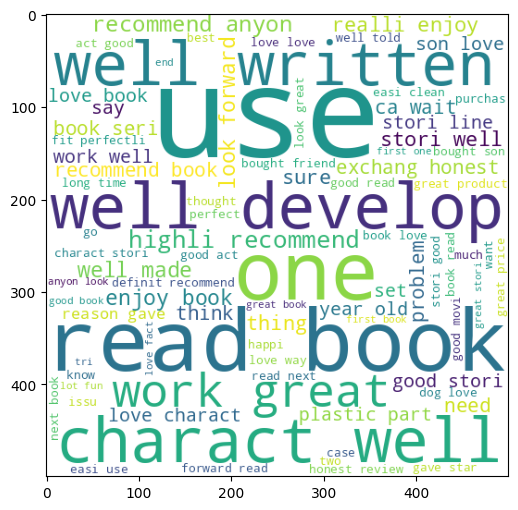

In [29]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
fake_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(fake_wc)

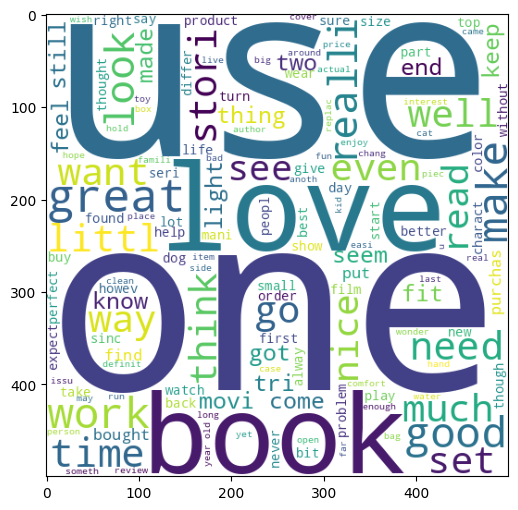

In [30]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
original_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(original_wc)

In [31]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [32]:
print(X.shape)
print(y.shape)

(40412, 3000)
(40412,)


In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=32)

In [34]:
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [35]:
clfs = {
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'xgb':xgb
}

In [36]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    
    return accuracy,precision

In [37]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

In [38]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [39]:
performance_df.reset_index(drop = True)

,Algorithm,Accuracy,Precision
0,LR,0.855004,0.855008
1,NB,0.840158,0.841281
2,RF,0.836323,0.838123
3,xgb,0.818013,0.818978
4,AdaBoost,0.739082,0.741638
5,DT,0.591365,0.648481
6,KN,0.503402,0.558478


In [40]:
mnb = MultinomialNB()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)

In [41]:
voting = VotingClassifier(estimators=[('LR', lrc), ('nb', mnb), ('RF', rfc)],voting='soft')

In [42]:
voting.fit(X_train,y_train)

VotingClassifier(estimators=[('LR',
                              LogisticRegression(penalty='l1',
                                                 solver='liblinear')),
                             ('nb', MultinomialNB()),
                             ('RF',
                              RandomForestClassifier(n_estimators=50,
                                                     random_state=2))],
                 voting='soft')

In [43]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.8665099591735742
Precision 0.8777580522444839


In [44]:
estimators = [('LR', lrc), ('nb', mnb), ('RF', rfc)]
final_estimator = RandomForestClassifier(n_estimators=50, random_state=2)

In [45]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [46]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.8535197327724855
Precision 0.8571073558648111


In [47]:
pickle.dump(tfidf,open('vectorizer.pkl','wb'))
pickle.dump(mnb,open('model.pkl','wb'))